In [44]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [45]:
df_raw = pd.read_csv('Datos/Transformados/close_limpio.csv')
symbols = df_raw['symbol'].unique()
dfs = {}
for symbol in symbols:
    df_symbol = df_raw[df_raw['symbol'] == symbol].copy()
    df_symbol = df_symbol.sort_values('fecha')
    df_symbol = df_symbol.set_index('fecha')
    dfs[symbol] = df_symbol[['close']].rename(columns={'close': 'Close'})

In [46]:
df_raw['fecha'] = pd.to_datetime(df_raw['fecha']).dt.date
df = df_raw.pivot(index='fecha', columns='symbol', values='close')
df.head()

symbol,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,KO,MCD,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V
fecha,,,,,,,,,,,,,,,,,,,,,
2018-06-06,194.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-07,193.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-08,191.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-11,191.16,NaN,NaN,NaN,156.350,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.88
2018-06-12,192.32,NaN,NaN,NaN,157.485,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,74.3,NaN,NaN,NaN,134.88


In [47]:
fecha_inicio = pd.to_datetime(df.index.min())
fecha_fin = pd.to_datetime(df.index.max())
splits_dict = {}
for symbol in df.columns:
    ticker = yf.Ticker(symbol)
    splits = ticker.splits
    if not splits.empty and not isinstance(splits.index, pd.DatetimeIndex):
        splits.index = pd.to_datetime(splits.index)
    if not splits.empty and splits.index.tz is not None:
        splits.index = splits.index.tz_convert(None)
    splits_filtrados = splits[(splits.index >= fecha_inicio) & (splits.index <= fecha_fin)] if not splits.empty else splits
    if not splits_filtrados.empty:
        splits_dict[symbol] = splits_filtrados
if splits_dict:
    print("Activos con splits detectados en el rango de fechas de tus datos:")
    for symbol, splits in splits_dict.items():
        print(f"{symbol}:\n{splits}")
else:
    print("Ningún activo ha tenido splits en el rango de fechas de tus datos.")
df_ajustado = df.copy()
for symbol in splits_dict.keys():
    splits = splits_dict[symbol]
    for fecha_split, factor in splits.items():
        if isinstance(fecha_split, pd.Timestamp):
            fecha_split_ts = fecha_split
        else:
            fecha_split_ts = pd.Timestamp(fecha_split)
        idx_ts = pd.to_datetime(df_ajustado.index)
        mask = idx_ts < fecha_split_ts
        df_ajustado.loc[mask, symbol] = df_ajustado.loc[mask, symbol] / factor
df_ajustado.head()

Activos con splits detectados en el rango de fechas de tus datos:
AAPL:
Date
2020-08-31 04:00:00    4.0
Name: Stock Splits, dtype: float64
MRK:
Date
2021-06-03 04:00:00    1.048
Name: Stock Splits, dtype: float64


symbol,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,KO,MCD,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V
fecha,,,,,,,,,,,,,,,,,,,,,
2018-06-06,48.5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-07,48.3750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-08,47.8775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-11,47.7900,NaN,NaN,NaN,156.350,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.88
2018-06-12,48.0800,NaN,NaN,NaN,157.485,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,74.3,NaN,NaN,NaN,134.88


In [48]:
df_ajustado.to_csv('Datos/Transformados/Accion_columna.csv')

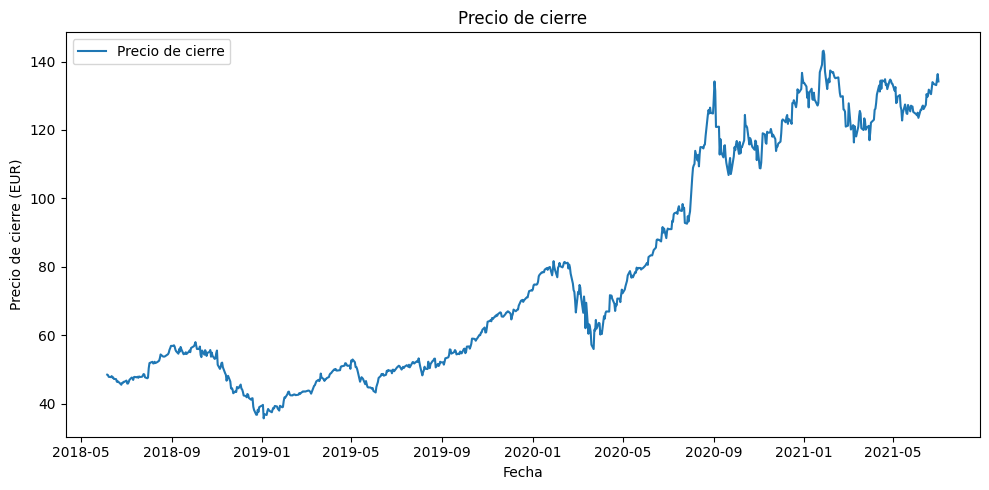

In [49]:
plt.figure(figsize=(10,5))
plt.plot(df_ajustado.index, df_ajustado['AAPL'], label='Precio de cierre')
plt.title(f'Precio de cierre')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre (EUR)')
plt.legend()
plt.tight_layout()
plt.show()

**Cambios al dia**

C:\Users\lande\AppData\Local\Temp\ipykernel_4128\3640970676.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rentabilidades_diarias = df_ajustado.pct_change() * 100
C:\Users\lande\AppData\Local\Temp\ipykernel_4128\3640970676.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


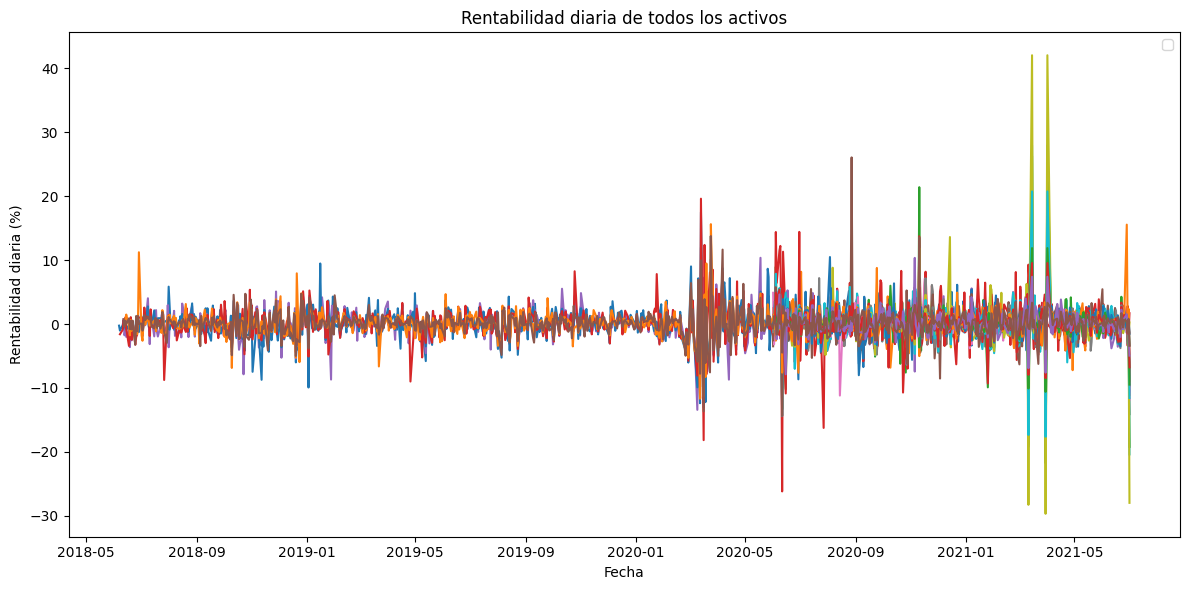

In [50]:
rentabilidades_diarias = df_ajustado.pct_change() * 100
plt.figure(figsize=(12,6))
for col in df_ajustado.columns:
    plt.plot(df_ajustado.index, rentabilidades_diarias[col])
plt.title('Rentabilidad diaria de todos los activos')
plt.xlabel('Fecha')
plt.ylabel('Rentabilidad diaria (%)')
plt.legend()
plt.tight_layout()
plt.show()

Define la función de **rentabilidad anualizada**:
$r_{periodo} = (1+r)^n -1$

In [51]:
def rentabilidad_anualizada(r_diaria, n=252):
    return (np.prod(1 + r_diaria) ** (n / len(r_diaria))) - 1

In [52]:
resultados = {}
for col in df_ajustado.columns:
    serie = df_ajustado[col].dropna()
    rent_diaria = rentabilidades_diarias[col].loc[serie.index].dropna()
    if len(serie) > 1 and len(rent_diaria) > 0:
        rent_media = rent_diaria.mean()
        rent_activa = (serie.iloc[-1] - serie.iloc[0]) / serie.iloc[0]
        r_diaria_decimal = rent_diaria / 100
        rent_anual = rentabilidad_anualizada(r_diaria_decimal, 252)
        resultados[col] = {
            'Rentabilidad media (%)': rent_media,
            'Rentabilidad activa (%)': rent_activa*100,
            'Rentabilidad anualizada (%)': rent_anual*100}
    else:
        resultados[col] = {'Rentabilidad media (%)': np.nan, 'Rentabilidad activa (%)': np.nan, 'Rentabilidad anualizada (%)': np.nan}
df_resultados = pd.DataFrame(resultados).T
df_resultados

,Rentabilidad media (%),Rentabilidad activa (%),Rentabilidad anualizada (%)
AAPL,0.151001,176.665410,38.011526
AMGN,0.015190,-3.840191,-3.487377
AXP,0.204033,61.917490,54.781669
BA,0.235498,60.012012,53.129610
CAT,0.056056,27.643904,8.064927
CRM,0.135174,33.865188,30.262988
CSCO,0.039694,3.304370,2.990754
CVX,0.048152,-1.902568,-1.726175
DIS,0.165096,49.339095,43.841402
DOW,0.175383,30.820450,27.574398


In [53]:
vol_diaria = rentabilidades_diarias.std()
vol_anual = vol_diaria * np.sqrt(252)
df_volatilidad = pd.DataFrame({'Volatilidad diaria': vol_diaria, 'Volatilidad anualizada': vol_anual})
df_volatilidad

,Volatilidad diaria,Volatilidad anualizada
symbol,,
AAPL,2.147329,34.087790
AMGN,2.417775,38.380990
AXP,2.499886,39.684462
BA,3.611129,57.324889
CAT,2.244013,35.622597
CRM,2.523207,40.054672
CSCO,2.354652,37.378939
CVX,3.317825,52.668840
DIS,2.057709,32.665118


**Volatilidad anualizada**: $\sigma*\sqrt(n)$

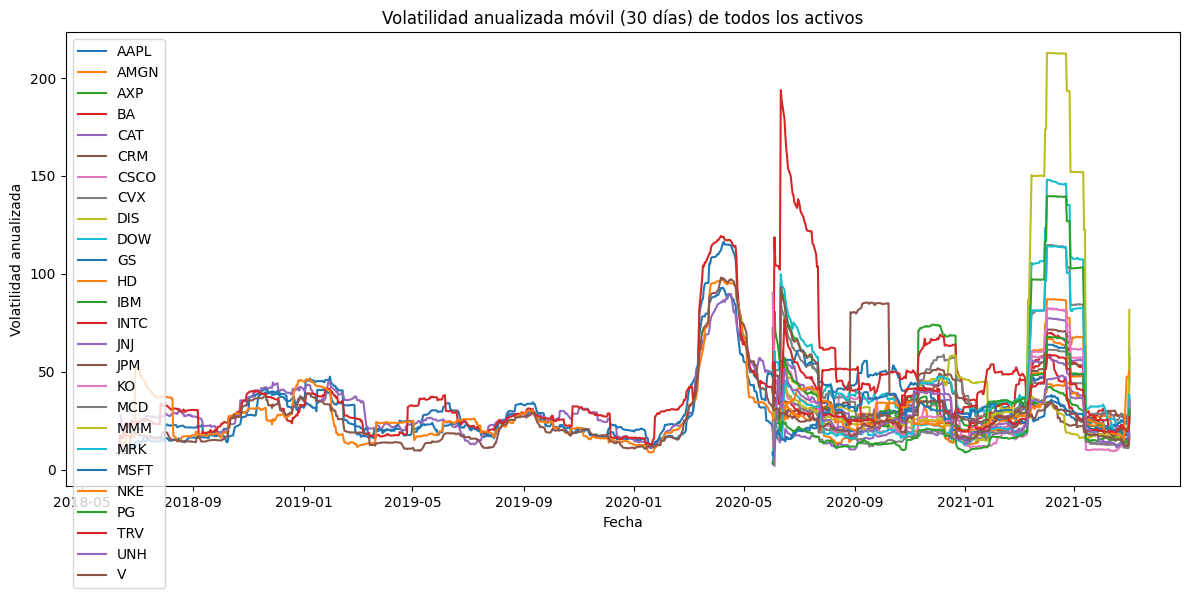

In [54]:
vol_30d = rentabilidades_diarias.rolling(window=30, min_periods=1).std() * np.sqrt(252)
plt.figure(figsize=(12,6))
for col in df_ajustado.columns:
    plt.plot(df_ajustado.index, vol_30d[col], label=col)
plt.title('Volatilidad anualizada móvil (30 días) de todos los activos')
plt.xlabel('Fecha')
plt.ylabel('Volatilidad anualizada')
plt.legend()
plt.tight_layout()
plt.show()

**Ratio de Sharpe**: $S_h = \frac{r-r_f}{\sigma}$

In [55]:
rf = 0.025
sharpe = {}
for col in df_ajustado.columns:
    vol_anual_col = vol_anual[col] if col in vol_anual else np.nan
    rent_anual_col = df_resultados.loc[col, 'Rentabilidad anualizada (%)'] if col in df_resultados.index else np.nan
    if not np.isnan(vol_anual_col) and not np.isnan(rent_anual_col) and vol_anual_col != 0:
        sharpe[col] = (rent_anual_col/100 - rf) / vol_anual_col
    else:
        sharpe[col] = np.nan
df_sharpe = pd.DataFrame({'Sharpe': sharpe})
df_sharpe

,Sharpe
AAPL,0.010418
AMGN,-0.001560
AXP,0.013174
BA,0.008832
CAT,0.001562
CRM,0.006931
CSCO,0.000131
CVX,-0.000802
DIS,0.012656
DOW,0.003969


$Drawdown_i = \frac{p_i}{p_{max}}$

$Max-drawdown = min(drawdown_i)_n$

In [56]:
max_drawdown = {}
for col in df_ajustado.columns:
    serie = df_ajustado[col].dropna()
    if len(serie) > 1:
        max_close = serie.cummax()
        drawdown = serie / max_close - 1
        max_drawdown[col] = drawdown.min()
    else:
        max_drawdown[col] = np.nan
df_drawdown = pd.DataFrame({'Max Drawdown': max_drawdown})
df_drawdown

,Max Drawdown
AAPL,-0.383931
AMGN,-0.234792
AXP,-0.203220
BA,-0.373579
CAT,-0.419463
CRM,-0.269938
CSCO,-0.258467
CVX,-0.352189
DIS,-0.161656
DOW,-0.292857


C:\Users\lande\AppData\Local\Temp\ipykernel_4128\348396274.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


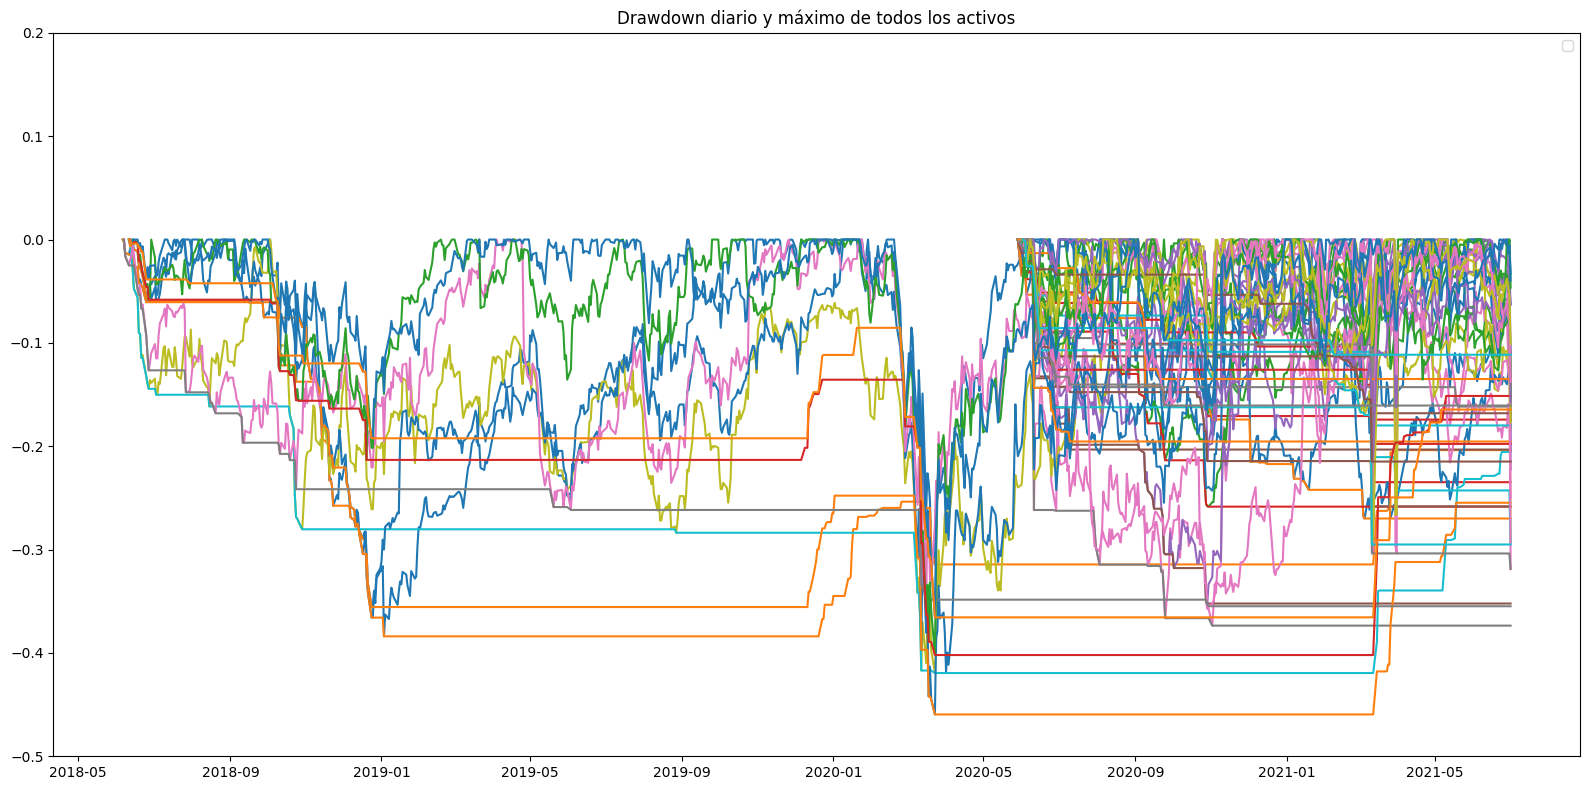

In [57]:
fig, ax = plt.subplots(figsize=(16, 8))
for col in df_ajustado.columns:
    serie = df_ajustado[col].dropna()
    if len(serie) > 1:
        max_close = serie.cummax()
        daily_drawdown = serie / max_close - 1
        max_daily_drawdown = daily_drawdown.rolling(window=252, min_periods=1).min()
        ax.plot(serie.index, daily_drawdown)
        ax.plot(serie.index, max_daily_drawdown)
ax.set_ylim(-0.5, 0.2)
ax.legend()
plt.title('Drawdown diario y máximo de todos los activos')
plt.tight_layout()
plt.show()